# Snake Charge Scan

To manipulate an electron confined by gate-defined quantum dot, it is essential to control the number of electron i.e. the chemical potential of each quantum dot and the tunnel coupling among quantum dots. The charge stability diagram (CSD) represents electrostatic characteristics of such a quantum dot system for a give charge configuration which suggests the operation point and the work window for further experiements. However, the CSD depends on the sweep direction of gate voltages thus a charge state hysteresis in quantum dots has been observed and inverstigated. [1]

[1] C. H. Yang, et al., Appl. Phys. Lett. 105, 183505 (2014)

In this tutorial, a pulse for the bi-directional sweep of a CSD is constructed so that the hysteresis of charge occupancy in a double quantum dot system can be measured. For ease of analysis, 2 different measurement windows namingly `('x_neg', 'x_pos')` are defined providing the possibliy of inspecting two sweep direction individually. Options of `plot` function in `qupulse.pulses.plotting` will be explored as well.

TODO: add some figures here...

## Task 1: Piece-wised voltage level

 ### Description:
 Let 2 AWG channels `(X, Y)` hold at a given set of voltages `(x_start, y_start)` for specific time durations `t_hold`.  

 ### Goal:  
 making a pulse without thinking the time consumption or the memory consumption.
 
 Firtly, we build a piece of voltage level with free parameters `t_hold` and `sample_rate` representing the time duration of such voltage level and the sample rate of AWG, respectively. With aforementioned parameters, a universal piece-wised pulse can be used as a building block of most experiments with flexibility of adjusting the pulse duration and hardward settings i.e. the sample rate of AWG.

In [59]:
import sympy
from qupulse.pulses import ConstantPT, RepetitionPT

sample_rate, n_segments, t_hold = sympy.sympify('sample_rate, n_segments, t_hold')
t_segment = n_segments / sample_rate

segment = ConstantPT(t_segment, {'X': 'x_start + x_i * x_step', 
                                 'Y': 'y_start + y_i * y_step'}
                    )
body = RepetitionPT(segment, t_hold // t_segment, measurements=[('M', 0, 't_hold')])

Now that a piece of voltage level is constructed with given voltages

A charge stability diagram can be abstracted by 2 nested for loop using `ForLoopPT` in qupulse. In order to define the name of measurement window for different sweep direction, the `ForLoopPT` is wrapped by a `MappingPT`.

The voltage resolution of the scan is described by `{x_step, y_step}` which are converted by qupulse according to the user inputs `{x_start, x_stop, N_x, y_start, y_stop, N_y}` representing the start voltage and stop voltages on different scan axis and the number of voltage levels of each axes.

In [60]:
from qupulse.pulses import MappingPT, ForLoopPT
inner_loop_fwd = MappingPT(ForLoopPT(body, 'x_i', 'N_x'), measurement_mapping={'M': 'x_pos'})
inner_loop_bwd = MappingPT(ForLoopPT(body, 'x_i', ('N_x - 1', -1, -1)), measurement_mapping={'M': 'x_neg'})

# concatinate two pulse templates by '@'
inner_loop = inner_loop_fwd @ inner_loop_bwd
outer_loop = ForLoopPT(inner_loop, 'y_i', 'N_y')

# here we make a linear interpolation of sweep axes.
snake_sweep_seg = MappingPT(outer_loop, parameter_mapping={'x_step': '(x_stop - x_start) / (N_x - 1)',
                                                           'y_step': '(y_stop - y_start) / (N_y - 1)'})

In [61]:

snake_cds = MappingPT(snake_sweep_seg,
                      parameter_mapping={'t_hold': 'cds_res'},
                      identifier='Snake_CDS')
print(snake_cds.parameter_names)

{'N_y', 'x_stop', 'y_start', 'x_start', 'n_segments', 'y_stop', 'cds_res', 'sample_rate', 'N_x'}


Let's generate a pulse for a bi-directional charge scan with voltage resolution 0.3V/point on x-axis and 0.4V/point on y-axis. The time resolution `cds_res` here is arbitarily chosen for demonstration.

In [62]:
default_params = {
    'n_segments': 2,
    'x_start': 0,
    'x_stop': 3,
    'y_start': 0,
    'y_stop': 2,
    'N_x': 10,
    'N_y': 5,
    'sample_rate': 1,
    'cds_res': 5
}

Now, we use `plot` function to inspect the positive sweep of channel X which is highlighted in the following plot.

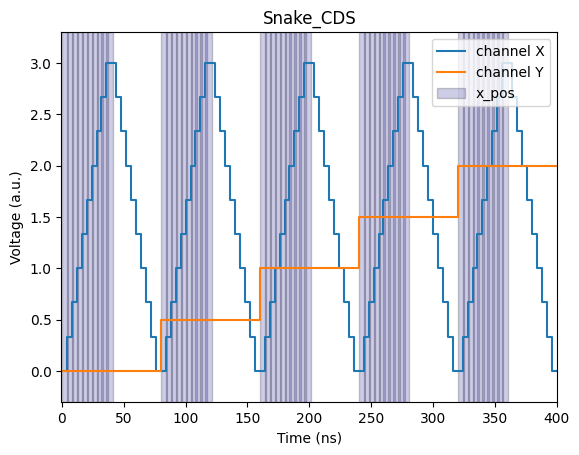

In [63]:
from qupulse.pulses.plotting import plot

_=plot(snake_cds, parameters=default_params, sample_rate=1, plot_measurements='x_pos')

Similaly the negative sweep is inspected by assigning the measurement window name `x_neg` to the input argument `plot_measurement` of `plot` function provided by qupulse.

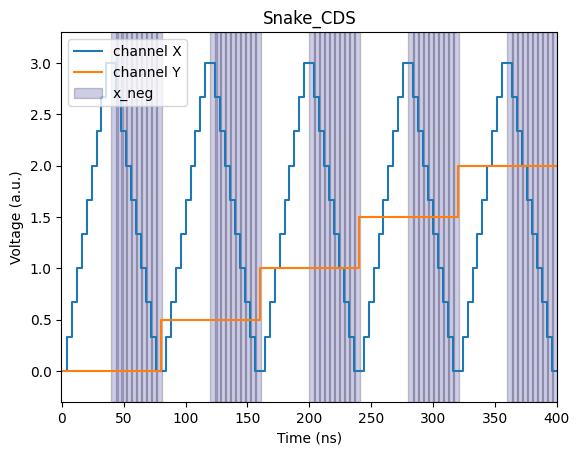

In [64]:
_=plot(snake_cds, parameters=default_params, sample_rate=1, plot_measurements='x_neg')

When we try to instantiate such a pulse it will take some time but not severe yet. However it is not a set of parameters with physical meanings. In general, a bandwidth of charge sensing falls in relatively low frequency range say slower than MHz. In addition, a voltage resolution of mV is required to resolve the charge occupancy of a quantum dot. Therefore the following parameters are used in a real experiment:

In [65]:
exp_params = {
    'n_segments': 192,          # empirically determined.
    'x_start': -50e-3,
    'x_stop': 50e-3,
    'y_start': 0,
    'y_stop': 0.1,              
    'N_x': 100,                 # voltage resolution: 1 mV
    'N_y': 100,                 # voltage resolution: 1 mV
    'sample_rate': 3.125e-3,    # AWG sample rate: 3.125 MHz
    'cds_res': 1e6              # time resolution: 1 ms
}

In [66]:
# Try with different time/voltage resolution or AWG sample rate by yourself!

import timeit
# using arbitary parameters for simplicity. 
simple_inst = timeit.timeit(lambda: snake_cds.create_program(parameters=default_params), number=1)
print(f'Elapsed time: {simple_inst} seconds')

# in a real experiment:
exp_inst = timeit.timeit(lambda: snake_cds.create_program(parameters=exp_params), number=1)
print(f'Elapsed time: {exp_inst} seconds')


Elapsed time: 0.05933679999998276 seconds
Elapsed time: 7.700837200000024 seconds


## Task 2: Simplify the pulse

With the current implementation the time consumption to instantiate pulse seems unecessarily long. But which step slows down the whole process significantly? Is there any space for improvement?  

The main concern by now is building everything by qupluse including the measurement window. Therefore the resolution of data acquisation and the pulse interpolation are coupled resulting in a sophisticated construction of pulse for a trivial task. In the following section, we will try to explore a way to optimize the pulse.

Supposing that the instrument for data acquisation can make on-fly process according to the measurement windows those defined in pulse templates. One needs only forward the starting time of a pulse and its time duration such that the data acquisation card will down-sample the raw data according to customized settings such as time resolution. In that case explicitly interpolating pulses is not necessary thus the nest level of pulse templates is simplified.

Let's firsly simplify the nest level of a linear sweep.  

In [67]:
from qupulse.pulses import PointPT, ConstantPT, AtomicMultiChannelPT
import sympy

tx_sweep = sympy.sympify('tx_sweep')

# equivalently: tx_sweep = N_x * cds_res but now qupulse only takes care of the duration per scanline.
# Because N_x: number of data points per scanline and cds_res: time resolution per data point
# are only required by data aquisation device instead of qupulse.

# make a linear sweep of channel X with 1 measurement window for the whole sweep time
# meanwhile define channel y that holding on at a voltage level during x_ramp.
scan_line = AtomicMultiChannelPT(
                PointPT([(0,      'x_start'),
                         (tx_sweep, 'x_stop', 'linear')], channel_names='X'),
                ConstantPT(tx_sweep, {'Y': 'y_start + y_step * y_i'}),
                measurements=[('M', 0, tx_sweep)])

A complete bi-directional charge scan can be assembled as follows:

In [68]:
from qupulse.pulses import MappingPT, TimeReversalPT, ForLoopPT

pos_sweep = MappingPT(scan_line, measurement_mapping={'M': 'x_pos'})
neg_sweep = MappingPT(TimeReversalPT(scan_line), measurement_mapping={'M': 'x_neg'})

loop = ForLoopPT(pos_sweep @ neg_sweep, 'y_i', 'N_y')

snake_cds = MappingPT(loop, parameter_mapping={'y_step': '(y_stop - y_start) / (N_y - 1)'})
print(snake_cds.parameter_names)

{'N_y', 'x_stop', 'y_start', 'x_start', 'y_stop', 'tx_sweep'}


Now the `inner_loop` in task 1 is simplified by using the keyword `linear` provided by `PointPT` and has less complexity of defining measurement windows. We can now plot the pulse again by `qupulse.pulse.plotting.plot`:

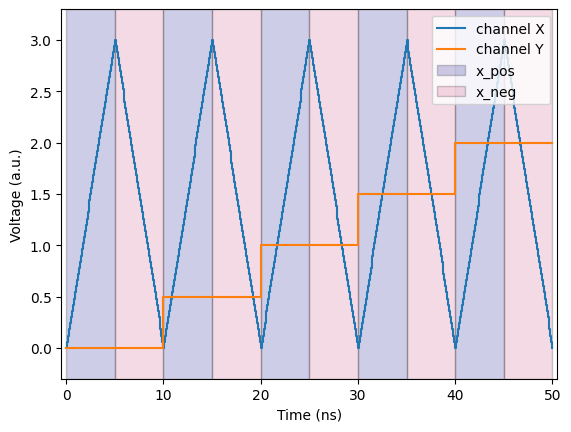

In [69]:
from qupulse.pulses.plotting import plot

default_params = {
    'tx_sweep': 5,
    'N_y': 5,
    'x_start': 0,
    'x_stop': 3,
    'y_start': 0,
    'y_stop': 2,
}
_ = plot(snake_cds, parameters=default_params, plot_measurements=('x_pos','x_neg'))

It is an obviously simple pulse definition, but how much time efficient do we gain from it remains unclear. Let's inspect the elapsed time of `creat_program`.  

In [70]:
import timeit

exp_params = {
    'tx_sweep': 100e6,          # 100 ms each scanline
    'x_start': -50e-3,
    'x_stop': 50e-3,
    'y_start': 0,
    'y_stop': 0.1,              
    'N_x': 100,                 # voltage resolution: 1 mV
    'N_y': 100,                
}

# using arbitary parameters for simplicity. 
simple_inst = timeit.timeit(lambda: snake_cds.create_program(parameters=default_params), number=1)
print(f'Elapsed time: {simple_inst} seconds')

# in a real experiment:
exp_inst = timeit.timeit(lambda: snake_cds.create_program(parameters=exp_params), number=1)
print(f'Elapsed time: {exp_inst} seconds')

Elapsed time: 0.00655929999993532 seconds
Elapsed time: 0.09900640000023486 seconds


Then how do we track on the memory usage of AWG? Don't know how to make it yet. Ask Simon.

In [79]:
# try to instantiate the pulse and compile it.
from qupulse._program.seqc import HDAWGProgramEntry, HDAWGProgramManager
from tests._program.seqc_tests import get_unique_wfs, DummyWaveform, complex_program_as_loop, complex_program_as_seqc

import numpy as np

prog = snake_cds.create_program(parameters=default_params)

defined_channels = snake_cds.defined_channels

unique_n = 100
unique_duration = 32

unique_wfs = get_unique_wfs(n=unique_n, duration=unique_duration, defined_channels=defined_channels)
same_wf = DummyWaveform(duration=48, sample_output=np.ones(48), defined_channels=defined_channels)

channels = defined_channels
markers = None
amplitudes = (1., 1.)
offsets = (0., 0.)
volatage_transformations = (lambda x: x, lambda x: x)
sample_rate = 1

root = complex_program_as_loop(unique_wfs, wf_same=same_wf)
seqc_nodes = complex_program_as_seqc(unique_wfs, wf_same=same_wf)

manager = HDAWGProgramManager()

manager.add_program('test', root, channels, markers, amplitudes, offsets, volatage_transformations, sample_rate)

seqc_program = manager.to_seqc_program()


(100, 32, {'X', 'Y'})



KeyboardInterrupt



## Task 3: Use convenient functions (with_*)

Equivalently the `scan_line` can be constructed by the helper functions `with_` since version 7.0.1?

In [17]:
from qupulse.pulses import PointPT
import sympy

tx_sweep = sympy.sympify('tx_sweep')

# use helper functions
forward = PointPT([(0,        'x_start'),
                   (tx_sweep, 'x_stop', 'linear')],
                  channel_names=('X', 'Y'),
                  measurements=[('M', 0, tx_sweep)])

backward = forward.with_time_reversal().with_mapping(measurement_mapping={'M': 'x_neg'})
forward = forward.with_mapping(measurement_mapping={'M': 'x_pos'})

scan_x = forward.with_appended(backward)
scan_line = scan_x.with_parallel_channels({'Y': 'y_start + y_step * y_i'})
scan_line = scan_line.with_mapping(parameter_mapping={'y_step': '(y_stop - y_start) / (N_y - 1)'})

snake_cds = scan_line.with_iteration('y_i', 'N_y')

In [18]:
print(scan_line.create_program)

<bound method PulseTemplate.create_program of MappingPulseTemplate(template=ParallelChannelPulseTemplate(template=SequencePulseTemplate(subtemplates=[MappingPulseTemplate(template=PointPulseTemplate(time_point_tuple_list=[(0, 'x_start', 'hold'), ('tx_sweep', 'x_stop', 'linear')],channel_names=('X', 'Y'),measurements=[('M', 0, 'tx_sweep')]),parameter_mapping=frozendict.frozendict({'x_start': ExpressionScalar('x_start'), 'x_stop': ExpressionScalar('x_stop'), 'tx_sweep': ExpressionScalar('tx_sweep')}),measurement_mapping={'M': 'x_pos'},channel_mapping={'Y': 'Y', 'X': 'X'}), MappingPulseTemplate(template=TimeReversalPulseTemplate(inner=PointPulseTemplate(time_point_tuple_list=[(0, 'x_start', 'hold'), ('tx_sweep', 'x_stop', 'linear')],channel_names=('X', 'Y'),measurements=[('M', 0, 'tx_sweep')])),parameter_mapping=frozendict.frozendict({'x_start': ExpressionScalar('x_start'), 'x_stop': ExpressionScalar('x_stop'), 'tx_sweep': ExpressionScalar('tx_sweep')}),measurement_mapping={'M': 'x_neg'},

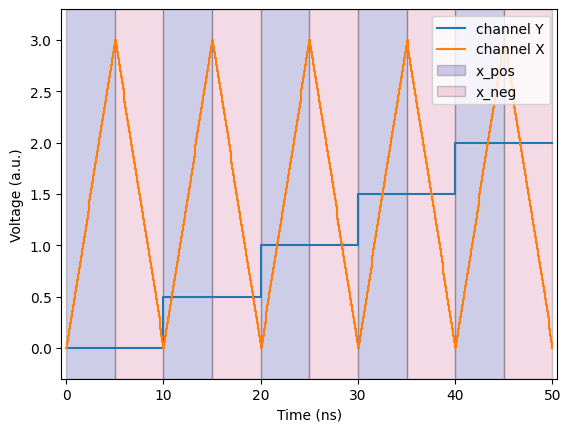

In [19]:
from qupulse.pulses.plotting import plot

default_params = {
    'tx_sweep': 5,
    'N_y': 5,
    'x_start': 0,
    'x_stop': 3,
    'y_start': 0,
    'y_stop': 2,
}
_ = plot(snake_cds, parameters=default_params, plot_measurements=('x_pos','x_neg'))